# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
from lib.Repository import *
from lib.Utility import *
from lib.modeling import *
from lib.preprocessing import *
from lib.preprocessing.HTMLParser import html_parser
from lib.viz import *

Allocated 16 CPUs


In [3]:
import time
import datetime


start_time = time.time()
raw_data = pd.read_csv('untrunc_data_cleaned.csv',index_col=0)

raw_data.info()

print(f'raw_data: {shape(raw_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11592 entries, 0 to 11591
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           11592 non-null  float64
 1   has_www                                 11592 non-null  float64
 2   has_iframe                              11592 non-null  float64
 3   int                                     11592 non-null  float64
 4   org                                     11592 non-null  float64
 5   gov                                     11592 non-null  float64
 6   in                                      11592 non-null  float64
 7   eu                                      11592 non-null  float64
 8   cn                                      11592 non-null  float64
 9   kr                                      11592 non-null  float64
 10  url_depth                               11592 non-null  fl

### Train Test Split

In [4]:
raw_data = raw_data.dropna()

X_train, X_test, y_train, y_test = train_test_split(
    raw_data.drop('label', axis=1),
    raw_data.label, test_size = 0.33, random_state=seed)

#### L-BFGS-B

In [119]:
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy


np.set_printoptions(suppress=True)

def costFunction(theta, X, y_true, lbd, left, right, sigma, feature_names):
    X = X.copy()

    I = y_true
    X = X.loc[:, feature_names]
    colnames = ['intercept', *X.columns]
    X.loc[:, 'intercept'] = 1
    X = X.loc[:, colnames]
    Y = y_true
    b = theta
    xb = X@b
    mid_idx = (Y > left) & (Y < right)
    left_idx = Y <= left
    right_idx = Y >= right

    # Ref: https://stats.stackexchange.com/questions/290833/likelihood-function-for-tobit
    # The uncensored records are those rows scraped from waybackmachine with label 0
    log_sigma = math.log(sigma)
    uncensored = scipy.stats.norm.pdf((Y[mid_idx] - xb[mid_idx])/ sigma)
    uncensored = pd.Series(uncensored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .apply(lambda x: x - log_sigma) \
        .sum()

    # The alive resources are considered to be censored. They are labeled as 1
    # Only right censored term applied for our case
    left_censored = scipy.stats.norm.cdf((left - xb[left_idx])/ sigma)
    left_censored = pd.Series(left_censored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .sum()
    right_censored = 1 - scipy.stats.norm.cdf((right - xb[right_idx])/ sigma)
    right_censored = pd.Series(right_censored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .sum()

    # Ref: http://bjlkeng.github.io/posts/probabilistic-interpretation-of-regularization/
    log_l1 = -pd.Series(theta).apply(abs).sum()

    # turn the argmax into argmin
    return -(uncensored + left_censored + right_censored + lbd * log_l1)


In [181]:
import scipy
import math
from sklearn.linear_model import LinearRegression as lm

left = 1
right = 2020 - 1990


feature_names = X_train.drop(['first_appear', 'avg_year', 'max_year', ], axis = 1).columns
feature_names = X_train.drop(['first_appear',], axis = 1).columns

uncensored_idx = (y_train > left) & (y_train < right)

model = lm().fit(X_train.loc[uncensored_idx, feature_names], y_train[uncensored_idx])
theta = [model.intercept_, *model.coef_]

df = len(y_train[uncensored_idx]) - 1
sigma = np.std(y_train[uncensored_idx] - model.predict(X_train.loc[uncensored_idx, feature_names]))/ math.sqrt(df)
print(sigma)
# sigma = 8.917527

# row based vector.
theta = pd.Series(theta).T

lbds = np.arange(1, 10, 1)

performance_matrix = pd.DataFrame(columns = ['alpha', *feature_names])

for lbd in lbds:
    opt_solution = scipy.optimize.minimize(
        costFunction,
        theta,
        args = (X_train, y_train, lbd, left, right, sigma, feature_names),
        method = 'L-BFGS-B',
        jac = False,
        options = {'maxiter': 100}
    )
    row = pd.DataFrame([lbd, *opt_solution.x]).T
    row.columns = ['alpha', 'intercept', *feature_names]
    performance_matrix = performance_matrix.append(row)

0.10691480092057379


In [180]:
opt_solution

      fun: 23277.528506840463
 hess_inv: <40x40 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -15.65858838,  -33.65857992,  -21.54993126,    4.01196303,
          8.98799044,    0.32741809,  -10.89683792,    9.00035957,
         -8.99999577,    9.00035957,   -8.99999577,    1.43190846,
         10.37187758,   12.98321877,  -30.95483407,  -24.43630365,
         -7.46258593,  -11.12930477, -415.23453547,   -8.79117579,
         17.45138434,   19.34749889,   11.48218871,   -7.04967533,
         11.35631464,   -8.07267497,    6.89833541,   -8.04175215,
        -12.66671461,   21.92391548,   10.27292456,    0.35579433,
         21.40295692,   12.02643034,  -31.70389391,  -38.20459824,
        -23.37619662,   -0.54387783,   11.30538294,   44.1330485 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 9102
      nit: 100
   status: 1
  success: False
        x: array([33.38015733, -2.17400901, -0.04336081,  0.55660802,  0.00312597,
        0.01824374, -0.22807

In [141]:
import math

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_importance_trending(X_train, feature_importance_matrix, title, offset=3):
    #         return
    feature_importance = feature_importance_matrix.groupby('alpha').agg(['mean'])[[*X_train.columns]]
    feature_importance.columns = X_train.columns.tolist()
    feature_importance['alpha'] = feature_importance.index

    column_names = X_train.columns
    lbds = feature_importance['alpha'].tolist()
    coef_matrix = feature_importance[X_train.columns]
    x_lab = 'Lambda'
    y_lab = 'Weight'
    plt.clf()
    plt.figure(figsize=(15, 10))
    for idx, col_name in enumerate(column_names):
        plt.plot(lbds, coef_matrix.iloc[:, idx], 'o-', linewidth=2, label=col_name)
#         c = coef_matrix.iloc[0, idx]
#         plt.annotate(col_name, (lbds[offset], coef_matrix.iloc[offset, idx]))

    plt.title(title, fontSize=25)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

    plt.legend(loc='upper right')
    plt.tight_layout()

    return plt

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

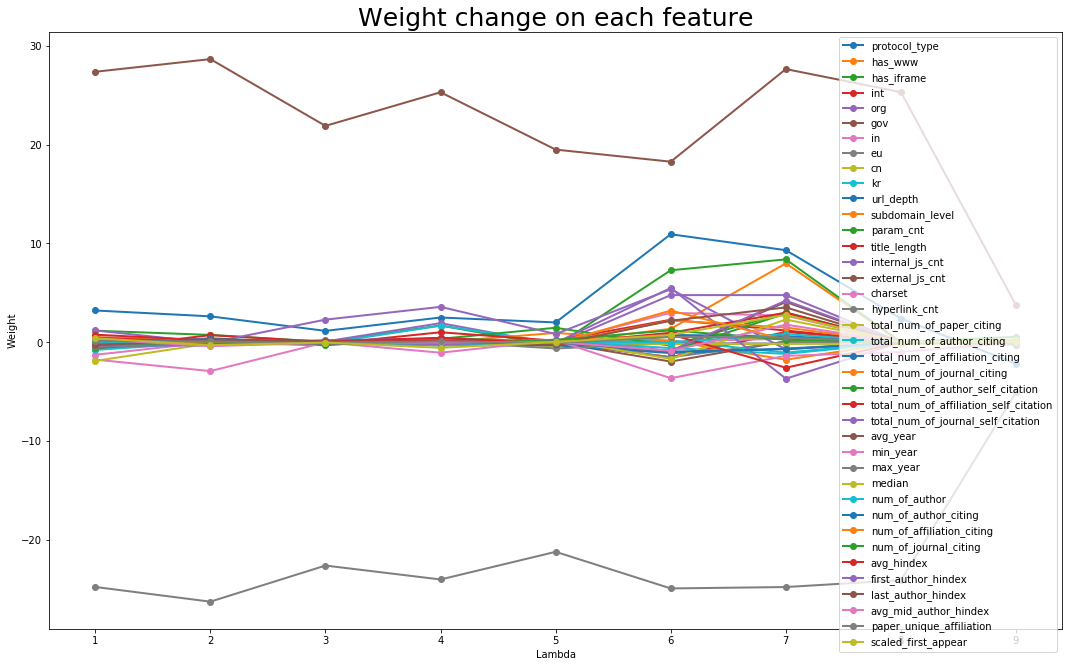

In [177]:
plot_importance_trending(X_train[feature_names], performance_matrix.drop('intercept', axis=1), 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

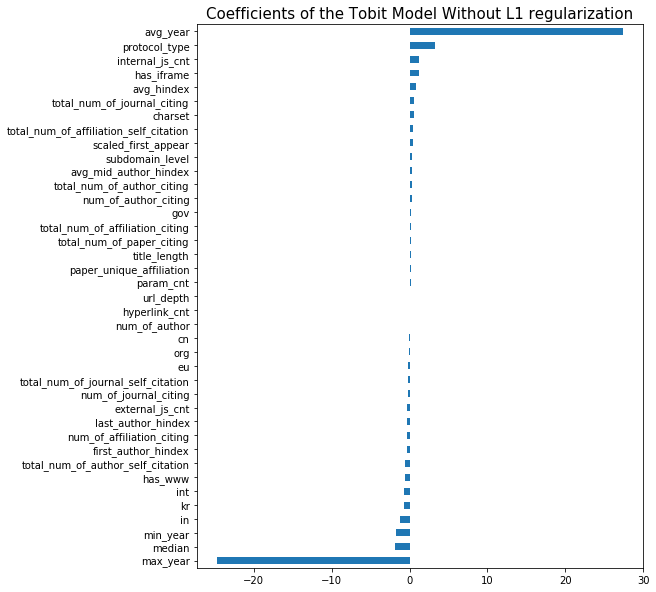

In [178]:
Visualizer.plot_feature_importance(
    performance_matrix[feature_names].iloc[0,:], X_train[feature_names].columns, 
    "Coefficients of the Tobit Model Without L1 regularization")

In [179]:
def get_pseudo_r2(X, y_true, coefficients, feature_names):
    X = X.copy()
    X.loc[:, 'intercept'] = 1
    colnames = ['intercept', *feature_names]
    X = X.loc[:, colnames]
    
    y = y_true
    yhat = X@b
    r2 = scipy.stats.pearsonr(y, yhat)
    return r2


get_pseudo_r2(X_test, y_test, performance_matrix[['intercept', *feature_names]].iloc[0,:], feature_names)
# performance_matrix[['intercept', *feature_names]].iloc[0,:]

(0.2618647677442023, 5.622162132815465e-61)

In [102]:
X = raw_data.drop('label', axis=1)
y = raw_data.label

scale = np.std(y[(y > left) & (y < right)])
print(scale)
# opt_solution = scipy.optimize.minimize(
#     costFunction,
#     theta,
#     args = (X, y, left, right, 0, scale, feature_names),
#     method = 'L-BFGS-B',
#     jac = False,
#     options = {'maxiter': 20}
# )

# b = opt_solution.x



# print(costFunction(b, X, y, 0, left, right, scale, feature_names))


3.7919433301083334


In [109]:
def costFunction(theta, X, y_true, lbd, left, right, sigma, feature_names):
    X = X.copy()

    I = y_true
    X = X.loc[:, feature_names]
    colnames = ['intercept', *X.columns]
    X.loc[:, 'intercept'] = 1
    X = X.loc[:, colnames]
    Y = y_true
    b = theta
    xb = X@b
    mid_idx = (Y > left) & (Y < right)
    left_idx = Y <= left
    right_idx = Y >= right

    # Ref: https://stats.stackexchange.com/questions/290833/likelihood-function-for-tobit
    # The uncensored records are those rows scraped from waybackmachine with label 0
    log_sigma = math.log(sigma)
    uncensored = scipy.stats.norm.pdf((Y[mid_idx] - xb[mid_idx])/ sigma)
    uncensored = pd.Series(uncensored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .apply(lambda x: x - log_sigma) \
        .sum()

    # The alive resources are considered to be censored. They are labeled as 1
    # Only right censored term applied for our case
    left_censored = scipy.stats.norm.cdf((left - xb[left_idx])/ sigma)
    left_censored = pd.Series(left_censored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .sum()
    right_censored = 1 - scipy.stats.norm.cdf((right - xb[right_idx])/ sigma)
    right_censored = pd.Series(right_censored) \
        .apply(lambda x: x + sys.float_info.epsilon) \
        .apply(math.log) \
        .sum()

    # Ref: http://bjlkeng.github.io/posts/probabilistic-interpretation-of-regularization/
    log_l1 = -pd.Series(theta).apply(abs).sum()

    # turn the argmax into argmin
    return -(uncensored + left_censored + right_censored + lbd * log_l1)

b = pd.Series([
        47.12664,
        0.5660426,
        -2.475189,
        -3.205918,
        7.356342,
        1.597967,
        2.407223,
        -5.061282,
        1.901022,
        -1.981829,
        1.863445,
        -0.1761744,
        0.03412519,
        2.198022,
        0.5271995,
        -1.548988,
        -0.2161744,
        4.037,
        0.1143784,
        -1.954171,
        2.131929,
        -0.4721643,
        1.809333,
        0.311385,
        -0.1351366,
        -0.2269391,
        -34.48553,
        -3.757532,
        38.17934,
        -0.2590699,
        4.796771,
        -0.9286313,
        -0.05856287,
        -0.4337209,
        -0.07293496,
        -0.1349584,
        0.5180091,
        -0.03138075,
        -0.5477498,
        2.7386,
    ], index=[
    'intercept',
    'protocol_type',
    'has_www',
    'has_iframe',
    'int',
    'org',
    'gov',
    'in',
    'eu',
    'cn',
    'kr',
    'url_depth',
    'subdomain_level',
    'param_cnt',
    'title_length',
    'internal_js_cnt',
    'external_js_cnt',
    'charset',
    'hyperlink_cnt',
    'total_num_of_paper_citing',
    'total_num_of_author_citing',
    'total_num_of_affiliation_citing',
    'total_num_of_journal_citing',
    'total_num_of_author_self_citation',
    'total_num_of_affiliation_self_citation',
    'total_num_of_journal_self_citation',
    'avg_year',
    'min_year',
    'max_year',
    'median',
    'num_of_author',
    'num_of_author_citing',
    'num_of_affiliation_citing',
    'num_of_journal_citing',
    'avg_hindex',
    'first_author_hindex',
    'last_author_hindex',
    'avg_mid_author_hindex',
    'paper_unique_affiliation',
    'scaled_first_appear',
])

scale=8.917527
print(costFunction(b, X, y, 0, left, right, scale, feature_names))

5413.872372799128


In [ ]:
pd.Series([1,2]).std()